#### Case 1: Isobaric evaporation of LNG in a large tank for long-term storage

This notebook sets up the isobaric evaporation of liquefied natural gas (LNG) in a 165,000 m $^3$ storage tank. This tank is representative of large-scale storage in above-ground tanks found in regasification terminals.


#### Determination of the wall heat partitioning from $T_{BOG} - T_{L} $

The following superheat data has been collected with two thermocouples, one at the liquid and one at the tank top in industrial storage tanks. 

- Sharafian (2019) reported a vapour superheat of 15 K, but didn't include the initial liquid filling.
- Industrial data shows a vapour superheating immediately after the evaporation for a LF = 26% of the following levels:
    - (-132 - -141) = 9 °C
    - (-130.5 - -141.2)= 10.7 °C

Hence, a range of 9 - 15 °C is representative of vapour superheating under low liquid levels. Assuming thermal equilibrium at the vapour liquid interface, $\Delta T_{sh} = T_{BOG} - T_{V,i} = T_{BOG} - T_{L} $, where $T_{V,i}$ is the vapour temperature at the interface.

In [1]:
# Ensure that python finds the submodules
import sys
sys.path.append("..") # Adds higher directory to python modules path.

# Scientific computing
import numpy as np

# Visualisation
import matplotlib.pyplot as plt

## Module imports
# Import the storage tank Class
from cryoevap.storage_tanks import Tank

# Import Cryogen class
from cryoevap.cryogens import Cryogen

#### Setup tank and cryogen properties

In [2]:
# LNG tank properties
Q_roof = 0 # Roof heat ingress / W
d_i = 76.4 # Internal diameter / m
d_o = 80   # External diameter / m
T_air = 298.15 # Temperature of the environment K

# Set overall heat transfer coefficient through the walls for liquid and vapour
U_L = 0.0371 # W/m2/K
U_V = 0.0371 # W/m2/K


# Specify heat transfer rate at the bottom to prevent ground heating
Q_b = 60000 # W, 

# Vertically orientated cylindrical tank volume
V_tank = 165000 #m^3

# Initial liquid filling / Dimensionless
LF = 0.97 

# Specify tank operating pressure
P = 116325 # Pa

# Initialize large-scale tank
large_tank = Tank(d_i, d_o, V_tank, LF)
large_tank.set_HeatTransProps(U_L, U_V, T_air, Q_b_fixed = Q_b, Q_roof = 0, eta_w = 0.90)

# Initialise cryogen
methane = Cryogen(name = "methane")
methane.set_coolprops(P)

# Set cryogen
large_tank.cryogen = methane

# Calculate initial evaporation rate
print("The initial evaporation rate of " + methane.name + " is %.1f kg/h" % (large_tank.b_l_dot * 3600))

The initial evaporation rate of methane is 852.0 kg/h


Calculate initial evaporation rate and transient period

In [3]:
# Calculate initial evaporation rate
print("The initial evaporation rate of " + methane.name + " is %.1f kg/h" % (large_tank.b_l_dot * 3600))

# Estimate transient period duration
print("Transient period = %.3f s " % large_tank.tau)

# Minimum number of hours to achieve steady state 
tau_h = (np.floor(large_tank.tau / 3600) + 1)

# Print simulation time of the transient period for short-term storage
print("Simulation time: %.0i h" % tau_h )

# Calculate boil-off rate
BOR = (large_tank.b_l_dot * 24 * 3600) / (large_tank.V * large_tank.LF * large_tank.cryogen.rho_L)
print("BOR = %.3f %%" % (BOR * 100))

The initial evaporation rate of methane is 852.0 kg/h
Transient period = 43124.455 s 
Simulation time: 12 h
BOR = 0.030 %


#### Simulation setup and execution

In [4]:
# Define vertical spacing
dz = 0.05

# Calculate number of nodes
n_z = 1 + int(np.round(large_tank.l_V/dz, 0))

# Define dimensionless computational grid
large_tank.z_grid = np.linspace(0, 1, n_z)

# Insulated roof
large_tank.U_roof = 0

# Define evaporation time as twice as the transient period
evap_time = 3600 *tau_h * 4

# Time step to record data, relevant for plotting integrated quantities
# such as the vapour to liquid heat transfer rate, Q_VL
large_tank.time_interval = 60

# Time step to plot each vapour temperature profile
large_tank.plot_interval = evap_time/6

# Simulate the evaporation
large_tank.evaporate(evap_time)

#### Visualisation of results

#### Vapour temperature

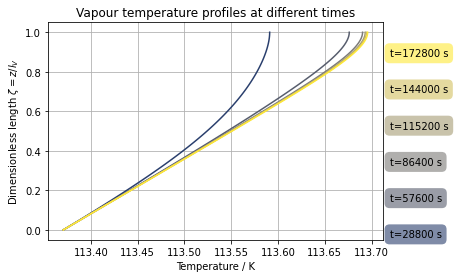

In [5]:
# Visualise the plot
large_tank.plot_tv()

Visualise liquid and vapour heat ingresses, $\dot{Q}_{\text{L}}$ and  $\dot{Q}_{\text{V}}$.

The plot also shows the vapour to liquid heat ingress, $\dot{Q}_{VL}$, and  the partition of the vapour heat ingress that is transferred to the interface by the wall directly, $\dot{Q}_{\text{V,w}}$

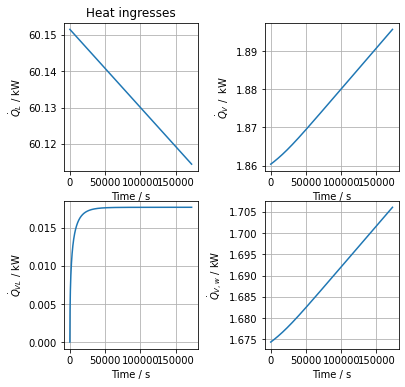

In [6]:
large_tank.plot_Q()

#### Plot liquid volume

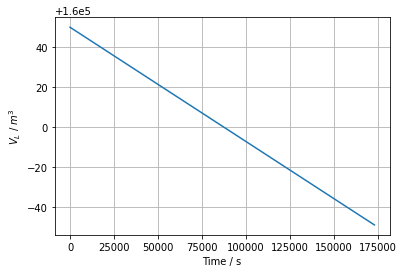

In [7]:
large_tank.plot_V_L()

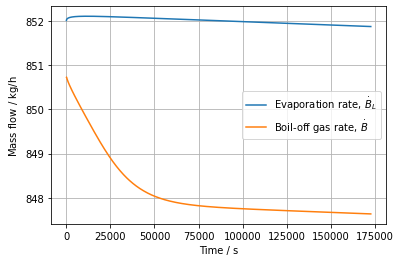

In [8]:
large_tank.plot_BOG(unit='kg/h')

Optional: CSV data export

If evaporation data is intended to be post-processed in another software, it can be exported readily with the help of the Pandas package.

In [9]:
# Import pandas 
import pandas as pd

In [10]:
# Create dataframe from dictionary
df_evap = pd.DataFrame.from_dict(large_tank.data)

# Save file to the current working directory
df_evap.to_csv('methane_165000m3.csv')

# Show the first five columns of the dataframe in console
df_evap.head()

,Time,Tv_avg,rho_V_avg,Q_VL,Q_L,Q_V,V_L,B_L,BOG,drho_V_avg,dV_L,Q_Vw
0,0.0,113.370493,2.061855,3.828316e-11,60151.526548,1860.356491,160050.000000,0.236668,0.236668,0.000000e+00,0.000000,1674.320842
1,60.0,113.370978,2.061846,2.012046e+00,60151.513660,1860.364492,160049.965707,0.236672,0.236312,-1.653480e-07,-0.000572,1674.328043
2,120.0,113.371460,2.061836,2.945827e+00,60151.500771,1860.372531,160049.931412,0.236674,0.236312,-1.648879e-07,-0.000572,1674.335278
3,180.0,113.371939,2.061826,3.609101e+00,60151.487882,1860.380597,160049.897119,0.236675,0.236309,-1.640406e-07,-0.000572,1674.342538
4,240.0,113.372416,2.061816,4.141001e+00,60151.474993,1860.388686,160049.862824,0.236676,0.236306,-1.633177e-07,-0.000572,1674.349818


In [11]:
# Calculates BOG rate after the transient period is reached
df_evap[df_evap['Time'] == 86400]['BOG'] * 3600

1440    847.787403
Name: BOG, dtype: float64

In [12]:
# Calculates increase in average vapour temperature during the first 86,400 s (1 day) of evaporation
dT_avg_trans = df_evap[df_evap['Time'] == 86400]['Tv_avg'].values - df_evap[df_evap['Time'] == 0]['Tv_avg'].values
print("The average vapour temperature increases %.3f K after 86,400 s" %dT_avg_trans[0])

# Calculates increase in average vapour temperature between 86,400 s (1 day) and 172,800 s (2 days) of evaporation
dT_avg_trans = df_evap[df_evap['Time'] == 172800]['Tv_avg'].values - df_evap[df_evap['Time'] == 86400]['Tv_avg'].values
print("The average vapour temperature increases %.3f K after 86,400 s" %dT_avg_trans[0])

The average vapour temperature increases 0.175 K after 86,400 s
The average vapour temperature increases 0.002 K after 86,400 s


In [13]:
df_evap[df_evap['Time'] == 0]['Tv_avg']  

0    113.370493
Name: Tv_avg, dtype: float64

In [14]:
adf_evap['BOG'] * 3600

NameError: name 'adf_evap' is not defined

In [ ]:
df_evap['BOG']*3600

0       852.005341
1       850.723254
2       850.721494
3       850.710983
4       850.701673
           ...    
2876    847.640550
2877    847.640460
2878    847.640369
2879    847.640279
2880    847.640188
Name: BOG, Length: 2881, dtype: float64

In [ ]:
# Rate of change of vapour temperature per day
dTv_late = np.diff(df_evap['Tv_avg'])[-1] / 60 * 86400
print("dTdv after pseudo-steady state = %.3f" % dTv_late)

NameError: name 'np' is not defined

In [ ]:
df_evap['Q_VL']


0       3.753420e-11
1       1.975802e+00
2       2.892771e+00
3       3.544108e+00
4       4.066440e+00
            ...     
2876    1.769597e+01
2877    1.769609e+01
2878    1.769621e+01
2879    1.769633e+01
2880    1.769646e+01
Name: Q_VL, Length: 2881, dtype: float64

#### References



F. Huerta, V. Vesovic, A realistic vapour phase heat transfer model for the weathering of LNG stored in large tanks, Energy, 174 (2019) 280-291.